In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Build the Dataset

In [27]:
class DeepCaloDataset(Dataset):
    def __init__(self, data_path, target_path, transform=None):
        """
        Initialize the dataset with data and target paths.
        
        Parameters:
        data_path (str): Path to the .npy file containing image data.
        target_path (str): Path to the .npy file containing target data.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = np.load(data_path).astype(np.float32)
        self.targets = np.load(target_path).astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        # Permute the sample to have the channel dimension first
        sample = np.transpose(sample, (2, 0, 1))  # From [56, 11, 4] to [4, 56, 11]

        target = np.expand_dims(target, -1)
        if self.transform:
            sample = self.transform(sample)

        return sample, target

In [28]:
# Define file paths
#base_path = '/Desktop/CodeFolder/PCS/dataset/DeepCalo10K'
base_path = '.'
train_data_path = f'{base_path}/dcalo_img_train.npy'
train_target_path = f'{base_path}/dcalo_img_train_target.npy'
val_data_path = f'{base_path}/dcalo_img_val.npy'
val_target_path = f'{base_path}/dcalo_img_val_target.npy'
test_data_path = f'{base_path}/dcalo_img_test.npy'
test_target_path = f'{base_path}/dcalo_img_test_target.npy'

In [29]:
# Create datasets
train_dataset = DeepCaloDataset(train_data_path, train_target_path)
val_dataset = DeepCaloDataset(val_data_path, val_target_path)
test_dataset = DeepCaloDataset(test_data_path, test_target_path)

In [30]:
# Create dataloaders
tr_batch_size = 64
test_batch_size = 16


train_loader = DataLoader(train_dataset, batch_size=tr_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

## Have a look at images for DeepCalo
Each image has a shape of (56, 11, 4), 4 channel currosponding to 4 layers if electromegnatic calorememter

In [31]:
import matplotlib.pyplot as plt

In [32]:

# Get the first batch 
data_iter = iter(test_loader)
batch = next(data_iter)

# Extract samples and targets
# Show the first 2 data
samples, targets = batch
samples, targets = samples[:2], targets[:2]

print(samples.shape)
print(targets.shape)

torch.Size([2, 4, 56, 11])
torch.Size([2, 1])


First image: 
Target: 146.55


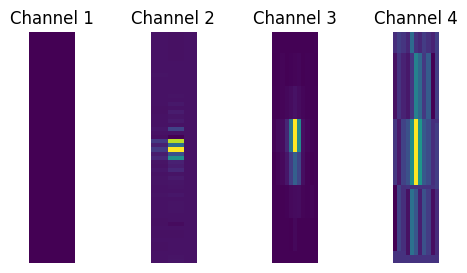

Seocnd image: 
Target: 101.04


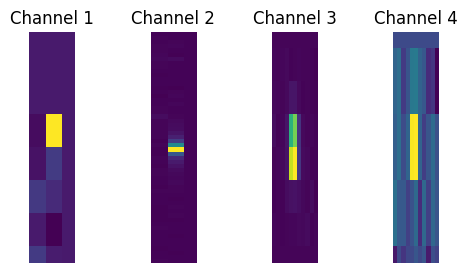

In [33]:
print("First image: ")
print(f"Target: {targets[0].item():.2f}")

# Plot each channel separately
plt.figure(figsize=(6, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[0][i])
    plt.axis('off')
    plt.title(f"Channel {i + 1}")

plt.show()

print("Seocnd image: ")
print(f"Target: {targets[1].item():.2f}")

plt.figure(figsize=(6, 3))

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(samples[1][i])
    plt.axis('off')
    plt.title(f"Channel {i + 1}")
plt.show()   


# DeepCalo Model

In [34]:
import torch.optim as optim

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
print(device)

cuda


In [37]:
import torch.nn as nn
import torch.nn.functional as F

class DeepCaloModelFull(nn.Module):
    def __init__(self):
        super(DeepCaloModelFull, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=(1, 5), mode='nearest')
        
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1_conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.block1_conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2_conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.block2_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.block3_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)

        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block4_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.block4_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.upsample(x)
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.block1_pool(x)
        x = F.relu(self.bn1_1(self.block1_conv1(x)))
        x = F.relu(self.bn1_2(self.block1_conv2(x)))

        x = self.block2_pool(x)
        x = F.relu(self.bn2_1(self.block2_conv1(x)))
        x = F.relu(self.bn2_2(self.block2_conv2(x)))

        x = self.block3_pool(x)
        x = F.relu(self.bn3_1(self.block3_conv1(x)))
        x = F.relu(self.bn3_2(self.block3_conv2(x)))

        x = self.block4_pool(x)
        x = F.relu(self.bn4_1(self.block4_conv1(x)))
        x = F.relu(self.bn4_2(self.block4_conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.relu(x)
        return x

In [51]:
# Instantiate the model and move it to the appropriate device
net = DeepCaloModelFull().to(device)

# Print the model summary
print(net)

DeepCaloModelFull(
  (upsample): Upsample(scale_factor=(1.0, 5.0), mode='nearest')
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1_conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_conv2): Conv2d(64, 64, kernel_siz

In [57]:
# Instantiate the model and move it to the appropriate device
net = DeepCaloModelFull().to(device)

# Print the model summary
print(net)

DeepCaloModelFull(
  (upsample): Upsample(scale_factor=(1.0, 5.0), mode='nearest')
  (conv1): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1_conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block2_conv2): Conv2d(64, 64, kernel_siz

In [58]:
import torchinfo
torchinfo.summary(net, (1, 4, 56, 11))

Layer (type:depth-idx)                   Output Shape              Param #
DeepCaloModelFull                        [1, 1]                    --
├─Upsample: 1-1                          [1, 4, 56, 55]            --
├─Conv2d: 1-2                            [1, 16, 56, 55]           1,616
├─BatchNorm2d: 1-3                       [1, 16, 56, 55]           32
├─MaxPool2d: 1-4                         [1, 16, 28, 27]           --
├─Conv2d: 1-5                            [1, 32, 28, 27]           4,640
├─BatchNorm2d: 1-6                       [1, 32, 28, 27]           64
├─Conv2d: 1-7                            [1, 32, 28, 27]           9,248
├─BatchNorm2d: 1-8                       [1, 32, 28, 27]           64
├─MaxPool2d: 1-9                         [1, 32, 14, 13]           --
├─Conv2d: 1-10                           [1, 64, 14, 13]           18,496
├─BatchNorm2d: 1-11                      [1, 64, 14, 13]           128
├─Conv2d: 1-12                           [1, 64, 14, 13]           36,9

In [59]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    # Define the loss function and the optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error (MAE) Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    print("Start Training:")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0  # Initialize the running loss for each epoch
        total_mae = 0.0  # Initialize the running MAE for each epoch
        total = 0

        model.train()  # Set the network to training mode

        for data in train_loader:
            # Get the inputs and labels from the data loader
            inputs, labels = data

            # Move the inputs and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()

            # Perform the forward pass: compute the network's outputs
            outputs = model(inputs)

            # Compute the loss using the criterion
            loss = criterion(outputs, labels)

            # Perform the backward pass: compute the gradients
            loss.backward()

            # Update the network parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current mini-batch
            running_loss += loss.item()

            # Calculate MAE for the current mini-batch
            total_mae += mean_absolute_error(outputs, labels) * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / len(train_loader)
        train_mae = total_mae / total
        train_accuracies.append(train_mae)
        train_losses.append(train_loss)

        # Evaluate on the test set
        model.eval()  # Set the network to evaluation mode
        test_mae = 0.0
        test_loss = 0.0
        total_test = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_mae += mean_absolute_error(outputs, labels) * inputs.size(0)
                total_test += inputs.size(0)

        test_loss /= len(test_loader)
        test_mae /= total_test
        test_accuracies.append(test_mae)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training MAE: {train_mae:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

    print('Finished Training')
    return train_accuracies, train_losses, test_accuracies, test_losses

In [60]:
# Call the training function
train_accuracies, train_losses, test_accuracies, test_losses = train_model(net, train_loader, test_loader, num_epochs=50)

Start Training:
Epoch [1/50], Training Loss: 24.7131, Training MAE: 24.7909, Test Loss: 14.6710, Test MAE: 14.6561
Epoch [2/50], Training Loss: 12.7272, Training MAE: 12.7337, Test Loss: 24.4915, Test MAE: 24.4487
Epoch [3/50], Training Loss: 13.5991, Training MAE: 13.5127, Test Loss: 41.3383, Test MAE: 41.3053
Epoch [4/50], Training Loss: 12.2192, Training MAE: 12.1299, Test Loss: 8.5149, Test MAE: 8.5070
Epoch [5/50], Training Loss: 11.1083, Training MAE: 11.1385, Test Loss: 7.4176, Test MAE: 7.4087
Epoch [6/50], Training Loss: 11.8496, Training MAE: 11.8641, Test Loss: 10.7757, Test MAE: 10.7623
Epoch [7/50], Training Loss: 11.7016, Training MAE: 11.6911, Test Loss: 10.4265, Test MAE: 10.4198
Epoch [8/50], Training Loss: 11.5659, Training MAE: 11.5340, Test Loss: 6.2304, Test MAE: 6.2259
Epoch [9/50], Training Loss: 12.0139, Training MAE: 12.0014, Test Loss: 20.8463, Test MAE: 20.8236
Epoch [10/50], Training Loss: 11.2531, Training MAE: 11.2766, Test Loss: 24.3707, Test MAE: 24.3477

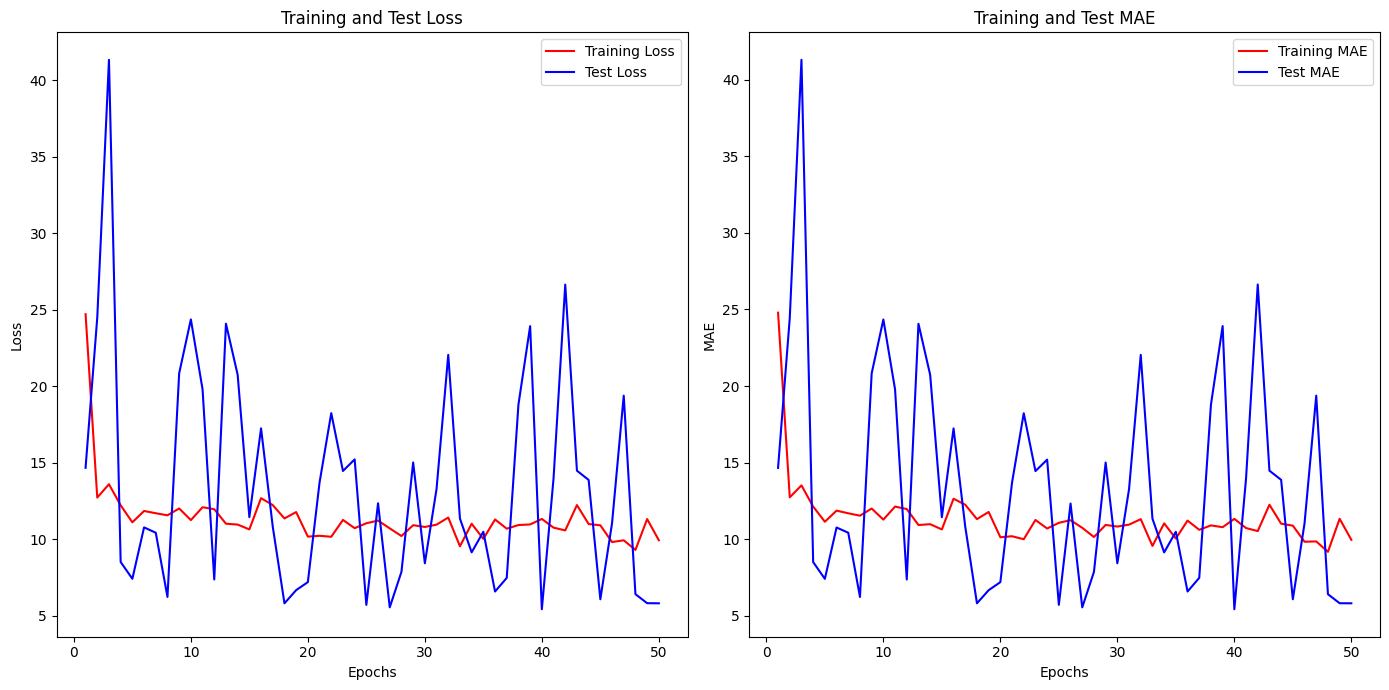

In [61]:


epochs = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(14, 7))

# Plotting Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Training Loss')
plt.plot(epochs, test_losses, 'b', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Test MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r', label='Training MAE')
plt.plot(epochs, test_accuracies, 'b', label='Test MAE')
plt.title('Training and Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
class SmallerDeepCaloModel(nn.Module):
    def __init__(self):
        super(SmallerDeepCaloModel, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=(1, 5), mode='nearest')
        
        self.conv1 = nn.Conv2d(4, 4, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(4)
        
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block1_conv1 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(8)
        self.block1_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(8)
        
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block2_conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(16)
        self.block2_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(16)
        
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block3_conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(32)
        self.block3_conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(32)

        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block4_conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(64)
        self.block4_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.upsample(x)
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.block1_pool(x)
        x = F.relu(self.bn1_1(self.block1_conv1(x)))
        x = F.relu(self.bn1_2(self.block1_conv2(x)))

        x = self.block2_pool(x)
        x = F.relu(self.bn2_1(self.block2_conv1(x)))
        x = F.relu(self.bn2_2(self.block2_conv2(x)))

        x = self.block3_pool(x)
        x = F.relu(self.bn3_1(self.block3_conv1(x)))
        x = F.relu(self.bn3_2(self.block3_conv2(x)))

        x = self.block4_pool(x)
        x = F.relu(self.bn4_1(self.block4_conv1(x)))
        x = F.relu(self.bn4_2(self.block4_conv2(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.relu(x)

        return x

In [63]:
# Instantiate the smaller model and move it to the appropriate device
small_net = SmallerDeepCaloModel().to(device)

In [64]:
# Call the training function
small_train_accuracies, small_train_losses, small_test_accuracies, small_test_losses = train_model(small_net, train_loader, test_loader, num_epochs=50)

Start Training:
Epoch [1/50], Training Loss: 29.4418, Training MAE: 29.5333, Test Loss: 15.9797, Test MAE: 15.9654
Epoch [2/50], Training Loss: 11.6692, Training MAE: 11.6544, Test Loss: 7.9282, Test MAE: 7.9157
Epoch [3/50], Training Loss: 12.9386, Training MAE: 12.9509, Test Loss: 7.7509, Test MAE: 7.7489
Epoch [4/50], Training Loss: 13.0718, Training MAE: 13.0510, Test Loss: 8.6068, Test MAE: 8.5984
Epoch [5/50], Training Loss: 11.2946, Training MAE: 11.2596, Test Loss: 10.5626, Test MAE: 10.5487
Epoch [6/50], Training Loss: 10.9986, Training MAE: 10.9522, Test Loss: 7.2966, Test MAE: 7.2855
Epoch [7/50], Training Loss: 11.8884, Training MAE: 11.8984, Test Loss: 7.0677, Test MAE: 7.0631
Epoch [8/50], Training Loss: 11.6115, Training MAE: 11.6330, Test Loss: 7.9122, Test MAE: 7.9008
Epoch [9/50], Training Loss: 11.4603, Training MAE: 11.4107, Test Loss: 23.5328, Test MAE: 23.5064
Epoch [10/50], Training Loss: 10.6700, Training MAE: 10.6754, Test Loss: 7.6377, Test MAE: 7.6258
Epoch [

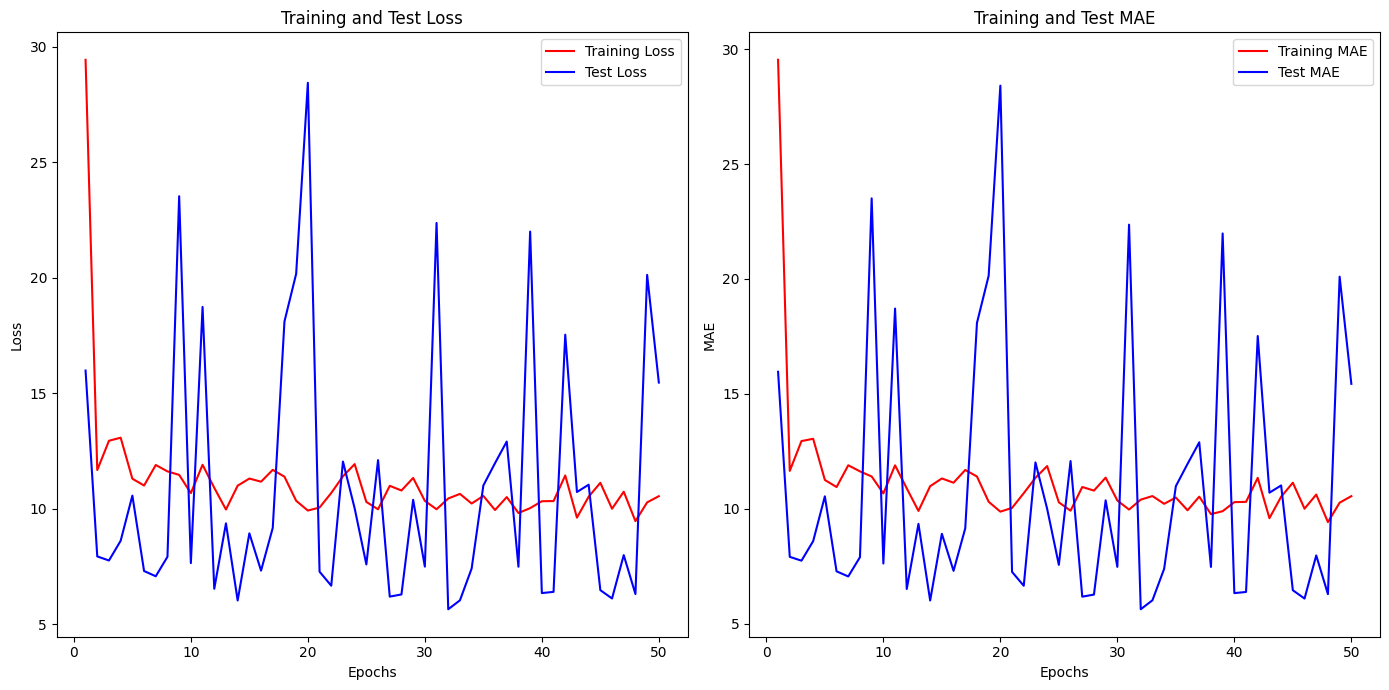

In [65]:


epochs = range(1, len(small_train_accuracies) + 1)
plt.figure(figsize=(14, 7))

# Plotting Training and Test Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, small_train_losses, 'r', label='Training Loss')
plt.plot(epochs, small_test_losses, 'b', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Test MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, small_train_accuracies, 'r', label='Training MAE')
plt.plot(epochs, small_test_accuracies, 'b', label='Test MAE')
plt.title('Training and Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()